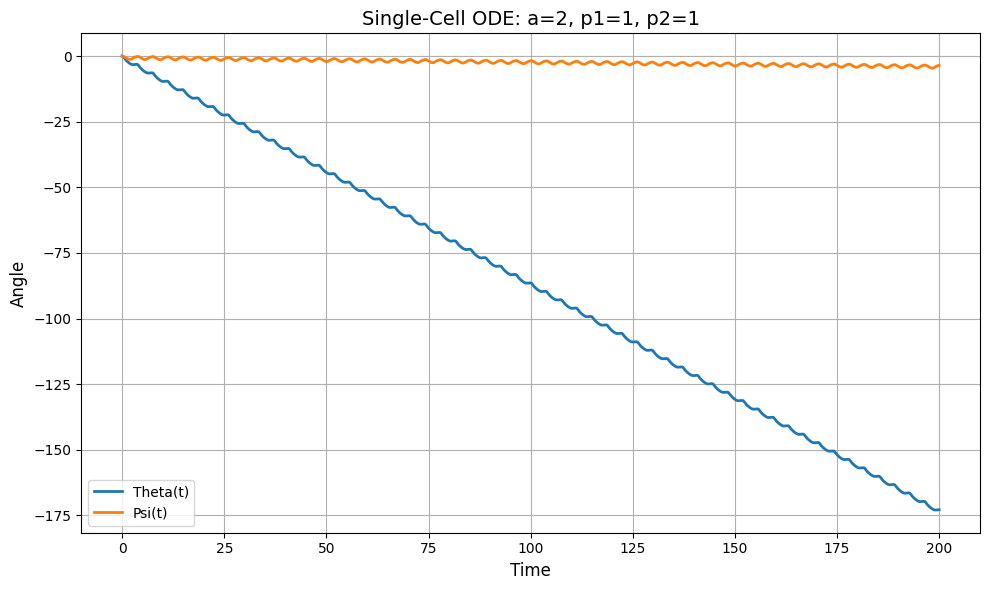

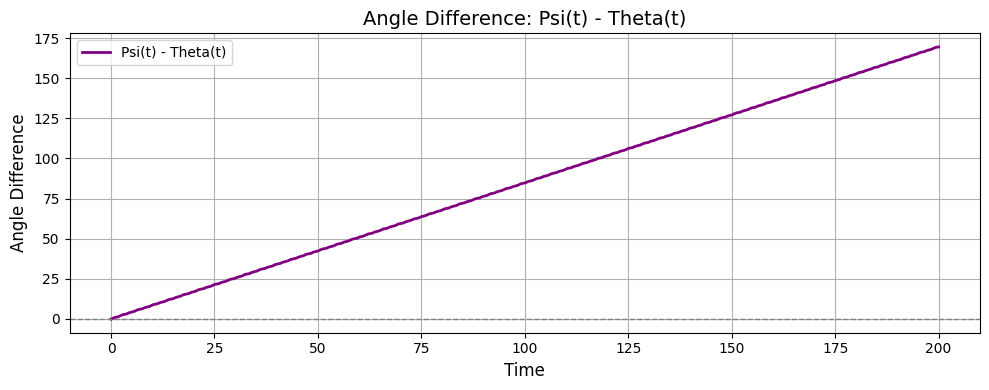

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import sin, cos, pi

def single_cell_ode(t, y, p1, p2, a):
    """
    ODE system describing a single cell with shape parameter 'a' and b=1.

    dTheta/dT = -1 + p1 * [ a*(a^2 - 1)*sin(2(Ψ-Θ)) / denom ],
    dPsi/dT   = -p2 * sin(2(Ψ - Θ)),

    where:
      denom = 2 * [ (a sin(Ψ - Θ))^2 + (cos(Ψ - Θ))^2 ]^(3/2)
    """
    Theta, Psi = y
    b = 1.0  # fixed

    sin_term = sin(2 * (Psi - Theta))
    cos_term = cos(Psi - Theta)
    sin_diff = sin(Psi - Theta)

    a_sin_part = (a**2) * sin_term
    b_sin_part = (b**2) * sin_term

    denom = 2.0 * ((a * sin_diff)**2 + (b * cos_term)**2)**1.5

    dTheta_dt = -1.0 - p1 * ((a * b) * (a_sin_part - b_sin_part) / denom)
    dPsi_dt   = -p2 * sin_term

    return [dTheta_dt, dPsi_dt]

def simulate_and_plot(p1=1.0, p2=1.0, a=2.0, t_max=100, dt=0.1):
    """
    Solves the ODE system and plots Theta(t) and Psi(t).

    Parameters:
        p1, p2: float - coupling strengths
        a: float       - shape parameter
        t_max: float   - end time of simulation
        dt: float      - time resolution
    Returns:
        t: np.ndarray       - time points
        Theta: np.ndarray   - Theta(t)
        Psi: np.ndarray     - Psi(t)
    """
    # Initial conditions
    Theta0 = 0.1
    Psi0 = 0
    y0 = [Theta0, Psi0]

    # Time points for evaluation
    t_eval = np.arange(0, t_max + dt, dt)

    # Solve the system using solve_ivp
    sol = solve_ivp(
        fun=lambda t, y: single_cell_ode(t, y, p1, p2, a),
        t_span=(0, t_max),
        y0=y0,
        t_eval=t_eval,
        method='RK45',
        rtol=1e-6,
        atol=1e-9
    )

    if not sol.success:
        print("ODE solver failed.")
        return None, None, None

    # Extract results
    t = sol.t
    Theta = sol.y[0]
    Psi = sol.y[1]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t, Theta, label='Theta(t)', linewidth=2)
    plt.plot(t, Psi, label='Psi(t)', linewidth=2)
    plt.title(f"Single-Cell ODE: a={a}, p1={p1}, p2={p2}", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Angle", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return t, Theta, Psi

# === Run simulation and get results ===
p1=1   # horizontal coupling strength
p2=1    # vertical coupling strength
a=2    # shape parameter (a > 1)
t_max=200 # total time to simulate
dt=0.001

t, Theta, Psi = simulate_and_plot(
    p1=p1,    # horizontal coupling strength
    p2=p2,    # vertical coupling strength
    a=a,     # shape parameter (a > 1)
    t_max=t_max, # total time to simulate
    dt=dt     # resolution (smaller = finer)
)

# === Plot Psi - Theta vs time ===
if t is not None:
    delta = Psi - Theta

    plt.figure(figsize=(10, 4))
    plt.plot(t, delta, label='Psi(t) - Theta(t)', color='purple', linewidth=2)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Angle Difference: Psi(t) - Theta(t)", fontsize=14)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Angle Difference", fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
# === Report initial angle difference ===
initial_diff = Psi[0] - Theta[0]
print(f"Initial Psi - Theta difference: {initial_diff:.6f} radians")

# === Detect steady-state angle difference ===
tolerance = 0.0005
window_sec = 10
window_size = int(window_sec / (t[1] - t[0]))  # number of points in 10 seconds

delta = Psi - Theta
steady_value = None
steady_start_time = None

for i in range(len(delta) - window_size):
    window = delta[i:i+window_size]
    max_dev = np.max(np.abs(window - window[0]))
    if max_dev < tolerance:
        steady_value = window[0]
        steady_start_time = t[i]
        break

if steady_value is not None:
    print(f"Steady-state detected: Psi - Theta ≈ {steady_value:.6f} radians")
    print(f"Steady behavior starts around t = {steady_start_time:.2f} seconds")
else:
    print("No steady-state angle difference detected within the specified tolerance.")


Initial Psi - Theta difference: -0.100000 radians
Steady-state detected: Psi - Theta ≈ -0.770374 radians
Steady behavior starts around t = 0.55 seconds


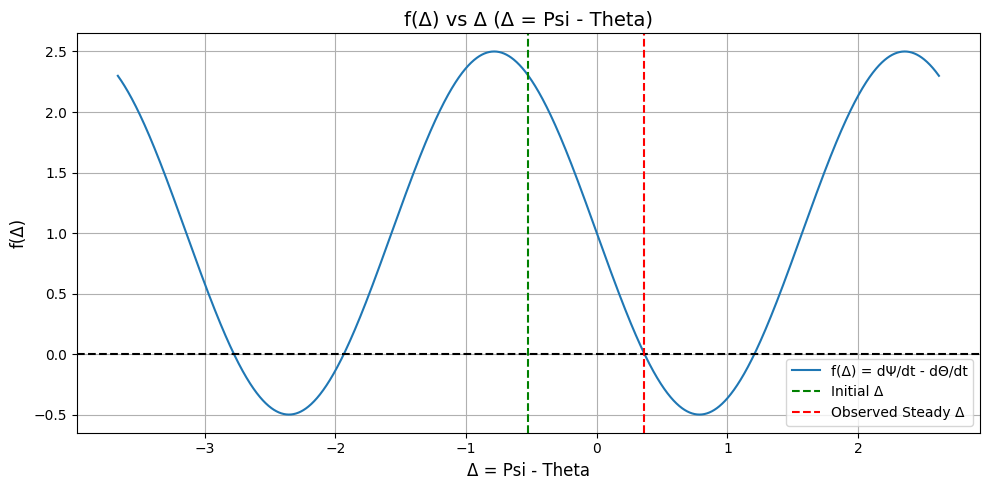

Zero crossings of f(Δ) found in the interval:
  Δ ≈ -2.777248 radians
  Δ ≈ -1.934880 radians
  Δ ≈ 0.365917 radians
  Δ ≈ 1.205142 radians

Initial Δ = -0.523599 radians
Observed steady-state Δ = 0.364372 radians
Nearest zero of f(Δ) = 0.365917 radians
✅ Match: Steady-state Δ ≈ predicted zero (diff = 0.001544)


In [3]:
def f_delta(delta, p1, p2, a):
    b = 1.0
    sin2d = np.sin(2 * delta)
    sin_d = np.sin(delta)
    cos_d = np.cos(delta)
    denom = 2 * ((a * sin_d)**2 + (b * cos_d)**2)**1.5

    dTheta_dt = -1.0 - p1 * ((a * b) * ((a**2 - b**2) * sin2d) / denom)
    dPsi_dt = -p2 * sin2d

    return dPsi_dt - dTheta_dt

# === Analyze f(delta) regardless of whether steady-state was found ===
delta_range = np.linspace(initial_diff - np.pi, initial_diff + np.pi, 2000)
f_vals = f_delta(delta_range, p1=p1, p2=p2, a=a)

# Plot f(δ)
plt.figure(figsize=(10, 5))
plt.plot(delta_range, f_vals, label='f(Δ) = dΨ/dt - dΘ/dt')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(initial_diff, color='green', linestyle='--', label='Initial Δ')
if steady_value is not None:
    plt.axvline(steady_value, color='red', linestyle='--', label='Observed Steady Δ')
plt.title("f(Δ) vs Δ (Δ = Psi - Theta)", fontsize=14)
plt.xlabel("Δ = Psi - Theta", fontsize=12)
plt.ylabel("f(Δ)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Find zero crossings
zero_crossings = []
for i in range(len(f_vals) - 1):
    if f_vals[i] * f_vals[i+1] < 0:
        zero_crossings.append((delta_range[i] + delta_range[i+1]) / 2)

if not zero_crossings:
    print("⚠️ No zero crossings found in f(Δ) over the interval.")
else:
    print("Zero crossings of f(Δ) found in the interval:")
    for z in zero_crossings:
        print(f"  Δ ≈ {z:.6f} radians")

if steady_value is not None:
    zero_crossings = np.array(zero_crossings)
    closest_zero = zero_crossings[np.argmin(np.abs(zero_crossings - initial_diff))]

    print(f"\nInitial Δ = {initial_diff:.6f} radians")
    print(f"Observed steady-state Δ = {steady_value:.6f} radians")
    print(f"Nearest zero of f(Δ) = {closest_zero:.6f} radians")

    diff = np.abs(steady_value - closest_zero)
    if diff < 0.01:
        print(f"✅ Match: Steady-state Δ ≈ predicted zero (diff = {diff:.6f})")
    else:
        print(f"⚠️ Mismatch: Steady-state Δ differs by {diff:.6f} radians")
else:
    print("\nℹ️ No steady-state Δ was detected from the numerical simulation.")
